In [292]:
from pyomo.environ import *
from pyomo.dae import *
import math
import matplotlib.pyplot as plt
import numpy as np

In [293]:
def get_model_variable_volume(xss={}, uss={}, ucon={}, xinit=0.3, uinit=200):
    # The dynamic model is
    # dc/dt = (cin - c(t)) u(t) / V - 2 * c(t)^3
    # c is the concentration, u is the inlet, V the volume (constant), 2 is the reaction constant
    # reaction is 3rd order 3A->B
    m = ConcreteModel()
    m.V = Param(default=50)  # reactor volume [m3]
    m.k = Param(default=2)  # reaction constant [m3/mol/s]
    m.t = ContinuousSet(bounds=(0, 10))  # time [s]
    m.c = Var(m.t, bounds=(0, 1))  # concentration [mol/m3]
    m.u = Var(m.t, bounds=(0, 800))  # inlet flowe rate [m3/s]

    m.dc = DerivativeVar(m.c, wrt=m.t)  # derivative dc/dt
    m.du = DerivativeVar(m.u, wrt=m.t, bounds=(None, None))  # derivative du/dt

    m.ode = Constraint(
        m.t, rule=lambda m, t: m.dc[t] == (1 - m.c[t]) * m.u[t] / m.V - m.k * m.c[t] ** 3
    )

    # discretize differential equations
    discretizer = TransformationFactory("dae.finite_difference")
    discretizer.apply_to(m, nfe=50, wrt=m.t, scheme="BACKWARD")

    # m.c[0].fix(xinit)
    # m.u[0].fix(uinit)

    # limits on how fast the flowrates can change
    m.der_u = Constraint(m.t, rule=lambda m, t: m.du[t] <= 20)
    m.der_l = Constraint(m.t, rule=lambda m, t: m.du[t] >= -20)

    p = {}
    time_ = [t for t in m.t]
    for t in m.t:
        k_ = list(xss.keys())
        v_ = list(xss.values())

        diff = [(t - i) ** 2 for i in xss.keys()]
        idx = np.argmin(diff)

        p[t] = v_[idx]

    def _intX(m, t):
        # return (m.c[t] - xss[math.ceil(t)])**2
        return (m.c[t] - p[t]) ** 2

    m.intX = Integral(m.t, wrt=m.t, rule=_intX)

    def _obj(m):
        return m.intX

    m.obj = Objective(rule=_obj)
    # m.obj = Objective(expr = sum( (m.c[t] - xss[math.ceil(t)])**2 for t in m.t), sense=minimize)
    return m, p

In [294]:
import deepxde as dde

In [295]:
import random
# generate a random production target
space = dde.data.GRF(T=10, kernel = 'RBF', length_scale=2) #
feats = -space.random(1)
xs = np.linspace(0, 10, num=51)[:, None] # - time 
y = 0.5 + 0.1* space.eval_batch(feats, xs) # - production target
xss = {}
for j in range(len(xs)):
    xss[xs[j][0]] = y[0][j]
uss = {}
x0_ = 0.2 #np.random.uniform(0,1,1)[0]
u0 = 250 #np.random.uniform(200,1500,1)[0]
ucon = 100
m,p = get_model_variable_volume(xss,uss,ucon, x0_,u0)


In [296]:
m.pprint()

2 Param Declarations
    V : Size=1, Index=None, Domain=Any, Default=50, Mutable=False
        Key : Value
    k : Size=1, Index=None, Domain=Any, Default=2, Mutable=False
        Key : Value

4 Var Declarations
    c : Size=51, Index=t
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True :  Reals
        0.2 :     0 :  None :     1 : False :  True :  Reals
        0.4 :     0 :  None :     1 : False :  True :  Reals
        0.6 :     0 :  None :     1 : False :  True :  Reals
        0.8 :     0 :  None :     1 : False :  True :  Reals
        1.0 :     0 :  None :     1 : False :  True :  Reals
        1.2 :     0 :  None :     1 : False :  True :  Reals
        1.4 :     0 :  None :     1 : False :  True :  Reals
        1.6 :     0 :  None :     1 : False :  True :  Reals
        1.8 :     0 :  None :     1 : False :  True :  Reals
        2.0 :     0 :  None :     1 : False :  True :  Reals
        2.2 :     0 :  None :  

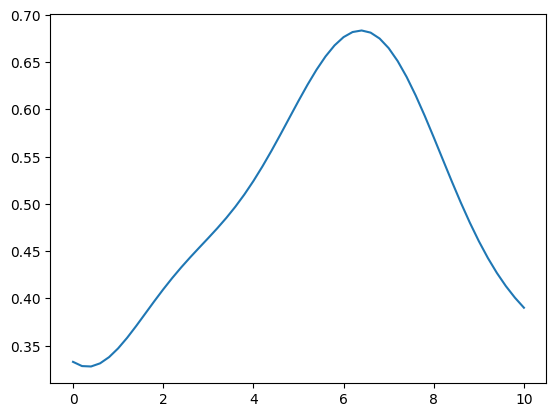

In [297]:
p
plt.plot(list(p.keys()),list(p.values()))


Text(0, 0.5, 'Concentration')

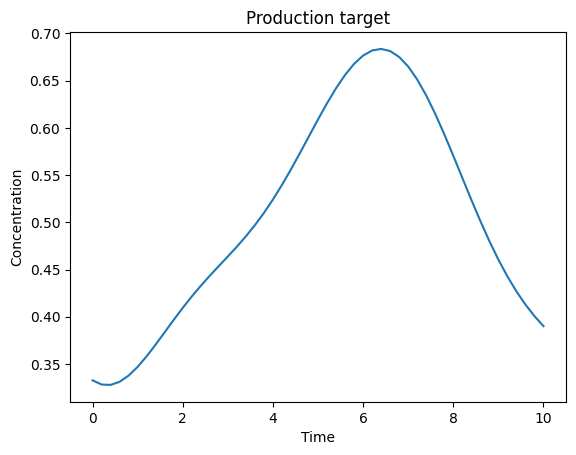

In [298]:
plt.title('Production target')
plt.plot([t for t in m.t], p.values())
plt.xlabel('Time')
plt.ylabel('Concentration')

In [299]:
solver = SolverFactory('ipopt')
res = solver.solve(m,tee=True)
# store the results
t_ = [t for t in m.t]
uin_sol = [m.u[t]() for t in m.t]
c_sol = [m.c[t]() for t in m.t]

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      453
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      102

Total number of variables............................:      204
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      102
                     variables with only upper bounds:        0
Total number of equality constraints.................:      151
Total number

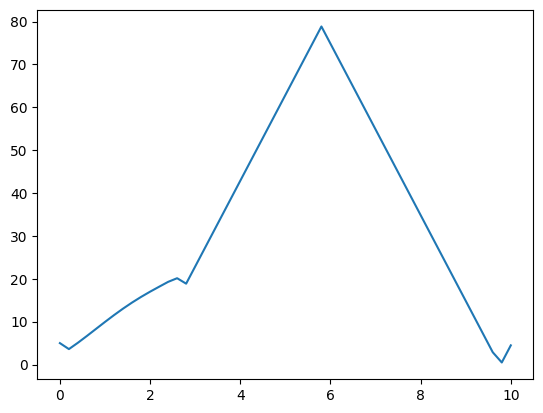

In [300]:
plt.plot(t_,uin_sol)
# make 1000s cases with data array of (p,u)